## Part 1: Get Data

In [ ]:
#Import Packages
import numpy as np
import tensorflow as tf
import cv2 
import imghdr
import os
import matplotlib.pyplot as plt

In [ ]:
#Get Data from Google Drive
#Kaggle Dataset can be found at https://www.kaggle.com/datasets/danielshanbalico/dog-emotion
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/My Drive/AIProjectData/data'
os.listdir(data_dir)

Mounted at /content/drive


['relaxed', 'sad', 'happy', 'angry']

# Part 2: Prepare Data

In [ ]:
#Sort through data to remove incompatible images
extensions = ['jpeg', 'jpg', 'png']
for group in os.listdir(data_dir):
  for img in os.listdir(os.path.join(data_dir, group)):
    path = os.path.join(data_dir, group, img)
    try:
      i = cv2.imread(path)
      tip = imghdr.what(path)
      if (tip not in extensions):
        print("Invalid file format at {}".format(path))
        os.remove(path)
    except Exception as ex:
      print("Problem with image {}".format(path))
      os.remove(path)

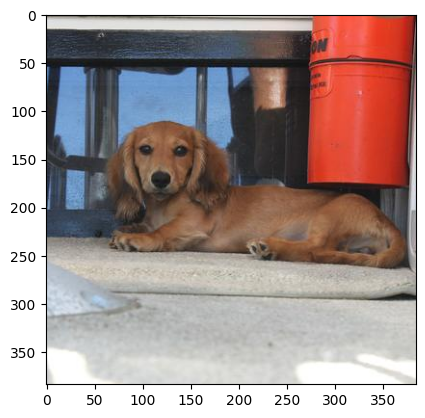

In [ ]:
#Show example image
img = cv2.imread('/content/drive/My Drive/AIProjectData/data/relaxed/0DZ2CGlS2MCjj93jPNlF6HcPqi1hMT621.jpg') 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #plt expects RGB, cv2 is BGR by default
plt.show()

In [ ]:
#Load data and specify trainig parameters
data = tf.keras.utils.image_dataset_from_directory(
    directory = data_dir,
    label_mode = 'categorical',
    color_mode = 'grayscale', #Will appear blue/yellow for higher contrast
    batch_size = 10,
    image_size = (512,512), 
    shuffle = True,
    seed = 18
)

Found 3996 files belonging to 4 classes.


In [ ]:
#Initialize numpy data iterator
data_iter = data.as_numpy_iterator()
batch = data_iter.next()
batch[0].shape
batch[1]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


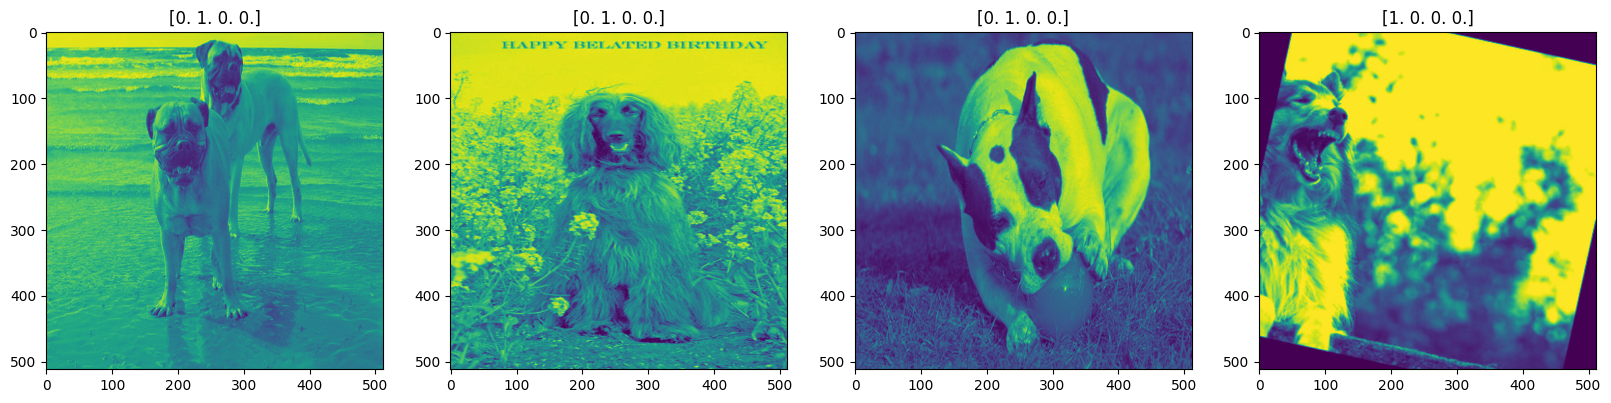

In [ ]:
#Check prepared images
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for i, img in enumerate(batch[0][:4]):
  ax[i].imshow(img.astype(int))
  ax[i].title.set_text(batch[1][i])

## Part 3: Preprocessing

In [ ]:
#Normalize values to between 0 to 1 in pipeline
data = data.map(lambda x,y: (x/255, y))
scaled_iter = data.as_numpy_iterator()

#Sanity check
print("min: ", scaled_iter.next()[0].min())
print("max: ", scaled_iter.next()[0].max())

min:  0.0
max:  1.0


In [ ]:
#Split data into train, test, and validation sets by batch
train_size = int(len(data)*0.8)
validation_size = int(len(data)*0.1)
test_size = int(len(data)*0.1)

data.shuffle(1000)

train_data = data.take(train_size)
validation_data = data.skip(train_size).take(validation_size)
test_data = data.skip(train_size + validation_size).take(test_size)

## Part 4: Build Model

In [ ]:
#Import packages
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, AveragePooling2D

In [ ]:
#Create Model
model = Sequential()

In [ ]:
#Add Model Layers
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(512, 512, 1))) #input
model.add(Dropout(0.6)) #dropout regularization to prevent overfitting
model.add(AveragePooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu')) #hidden
model.add(Dropout(0.6)) #dropout regularization to prevent overfitting
model.add(AveragePooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu')) #hidden
model.add(Dropout(0.6)) #dropout regularization to prevent overfitting
model.add(AveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax')) #output

In [ ]:
#Compile
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 16)      160       
                                                                 
 dropout (Dropout)           (None, 510, 510, 16)      0         
                                                                 
 average_pooling2d (AverageP  (None, 255, 255, 16)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      4640      
                                                                 
 dropout_1 (Dropout)         (None, 253, 253, 32)      0         
                                                                 
 average_pooling2d_1 (Averag  (None, 126, 126, 32)     0         
 ePooling2D)                                            

# Part 5: Training

In [ ]:
#Set up performance logging
log_dir = '/content/drive/My Drive/AIProjectData/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
#Fit Model
hist = model.fit(train_data, epochs=40, validation_data=validation_data, callbacks=[tensorboard_callback], shuffle=True)

Epoch 1/40
320/320 [==============================] - 1189s 4s/step - loss: 1.3561 - accuracy: 0.3153 - val_loss: 1.2881 - val_accuracy: 0.3250
Epoch 2/40
320/320 [==============================] - 1202s 4s/step - loss: 1.2761 - accuracy: 0.3572 - val_loss: 1.2973 - val_accuracy: 0.3225
Epoch 3/40
320/320 [==============================] - ETA: 0s - loss: 1.2381 - accuracy: 0.3887

In [ ]:
#Plot Performance

#loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='training loss')
plt.plot(hist.history['val_loss'], color='red', label='validation loss')
fig.suptitle('Loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='training accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='validation accuracy')
fig.suptitle('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Part 6: Test Data



In [ ]:
#Imoprt and instantiate metrics
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [ ]:
#Predict test values and compare to actual values
for batch in test_data.as_numpy_iterator():
  x, y = batch
  predicted_y = model.predict(x).round()
  precision.update_state(y, predicted_y)
  recall.update_state(y, predicted_y)
  accuracy.update_state(y, predicted_y)

In [ ]:
#Show performance
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

# Part 7: New Data

In [ ]:
#Find out how my dog Geddy feels when he has his raccoon toy
img = cv2.imread('/content/drive/My Drive/AIProjectData/Ged.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_resized = cv2.resize(img, (512, 512))
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
img_reshaped = np.expand_dims(img_gray, axis=-1)
img_norm = img_reshaped / 255.0
img_final = np.expand_dims(img_norm, axis=0)
prediction = model.predict(img_final)
prediction.round()

Geddy is happy!